## Import Packages

In [1]:
# By: Darren Upton
# Modeled on Code By: Kishan Rajput

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras import datasets, layers, models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import pickle
import seaborn as sns

#Stuff for ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve

from keras import backend as K

from matplotlib.colors import LogNorm


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6mzecy08 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


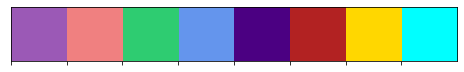

In [2]:
best_colors = ["#9b59b6",
               "lightcoral",
               "#2ecc71","cornflowerblue","indigo",#"darkorange",
               "firebrick","gold",
               "cyan"#"magenta"
              ]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

## Import Data

In [3]:
%%time

#Full
raw_sim_df = pd.read_csv("Sim_CSV/Sim_Pencil_AllEvents_TID1.csv")
raw_bkg_df = pd.read_csv("Sim_CSV/Sim_Pencil_Bkg.csv")

#Cher Arrays
raw_sim_cher = pd.read_csv("Sim_CSV/Sim_Pencil_CherChannels_AllEvents_TID1.csv", 
                          names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_sim_cher["pid"] = raw_sim_df["pid"]

raw_bkg_cher = pd.read_csv("Sim_CSV/Bkg_CherChannels.csv", 
                           names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_bkg_cher["pid"] = raw_bkg_df["pid"]

#raw_sim_df["Npesum"] = raw_sim_df.iloc[:,]

sim_df = raw_sim_df #[raw_sim_df["GEM00_Edep"]>35e-6]#[(raw_sim_df["PreShSum"]>0)].reset_index(drop=1)
bkg_df = raw_bkg_df #[GEM00_Edep >35e-6]#[(raw_bkg_df["PreShSum"]>0)&(raw_bkg_df["ShowerSum"]>0)].reset_index(drop=1)

sim_cher = raw_sim_cher
bkg_cher = raw_bkg_cher

sim_df

CPU times: user 1min 5s, sys: 8.97 s, total: 1min 14s
Wall time: 1min 15s


,# rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM01_Etot,GEM11_n,GEM11_np,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,theta,NCh
0,0.0003,0.0,0.0,0.0,-0.234481,2.871560e-17,0.721657,0.758795,11.0,743.066040,...,0.041197,1.0,47.0,0.000904,0.000904,0.000904,0.036460,27.0,18.000007,8.0
1,0.0003,0.0,0.0,0.0,-2.981923,3.651803e-16,9.177417,9.649707,11.0,6910.143066,...,0.058279,1.0,30.0,0.002967,0.002967,0.002967,0.032077,35.0,17.999995,10.0
2,0.0003,0.0,0.0,0.0,-0.911992,1.116868e-16,2.806822,2.951267,11.0,2877.891602,...,0.048772,1.0,33.0,0.000547,0.000547,0.000547,0.024543,25.0,17.999995,7.0
3,0.0003,0.0,0.0,0.0,-2.397427,2.936001e-16,7.378521,7.758236,11.0,7744.224609,...,0.031277,1.0,53.0,0.000286,0.000286,0.000286,0.020833,25.0,17.999995,8.0
4,0.0003,0.0,0.0,0.0,-2.853923,3.495048e-16,8.783473,9.235490,11.0,7368.849121,...,0.034688,1.0,74.0,0.000818,0.000818,0.000818,0.026032,33.0,17.999995,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000987,20.0000,0.0,0.0,0.0,-1.573952,1.927535e-16,4.844126,5.093416,-211.0,5085.679688,...,0.028306,1.0,5.0,0.000463,0.000463,0.000463,0.034769,6.0,17.999995,1.0
5000988,20.0000,0.0,0.0,0.0,-2.191752,2.684122e-16,6.745520,7.092659,-211.0,7085.326660,...,0.019737,1.0,5.0,0.000079,0.000079,0.000079,0.033819,21.0,18.000007,5.0
5000989,20.0000,0.0,0.0,0.0,-1.127889,1.381266e-16,3.471285,3.649925,-211.0,3640.323242,...,0.025422,1.0,5.0,0.000477,0.000477,0.000477,0.021713,0.0,18.000007,0.0
5000990,20.0000,0.0,0.0,0.0,-2.760364,3.380470e-16,8.495525,8.932724,-211.0,8924.052734,...,0.029711,1.0,5.0,0.000736,0.000736,0.000736,0.029953,31.0,17.999995,7.0


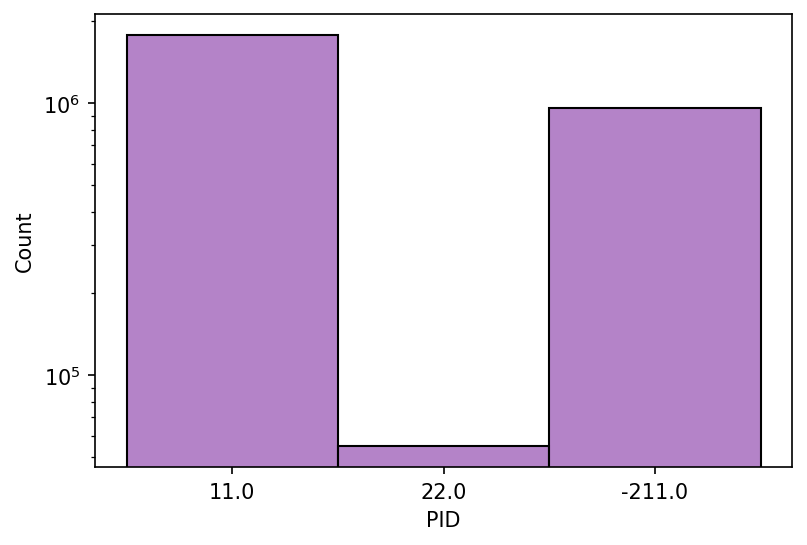

In [4]:
plt.figure(dpi=150)
plt.xlabel("PID")
sns.histplot(sim_df[raw_sim_df["Npesum"]>0], x=sim_df[raw_sim_df["Npesum"]>0]["pid"].astype(str))#, weights="# rate")
plt.yscale("log")


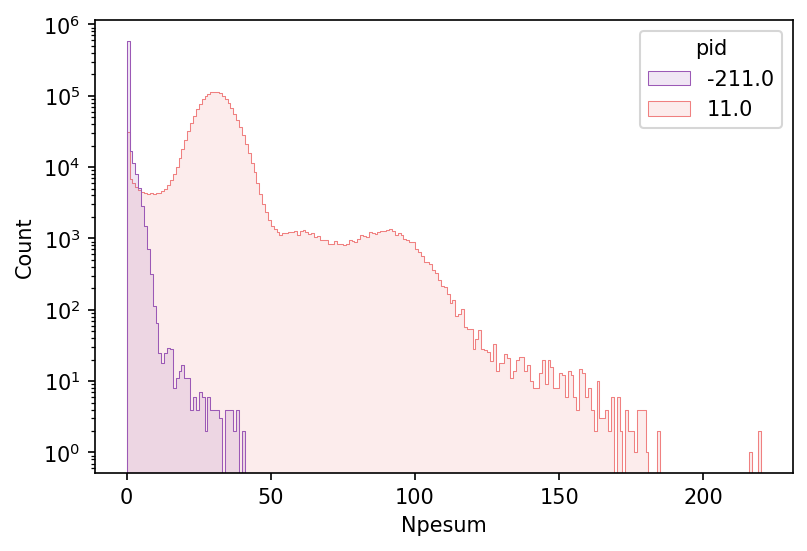

In [5]:
plt.figure(dpi=150)
sns.histplot(sim_df[(sim_df["pid"]==11) | ((sim_df["pid"]==-211) & (sim_df["p"]<5))], 
             x="Npesum", binwidth=1, hue="pid",
             element="step", palette=sns.color_palette(best_colors[:-6]), alpha=0.15, linewidth=0.5)
plt.yscale("log")

In [15]:
len(sim_df["p"][(sim_df["pid"]==11) & (sim_df["p"]<.1)])

266

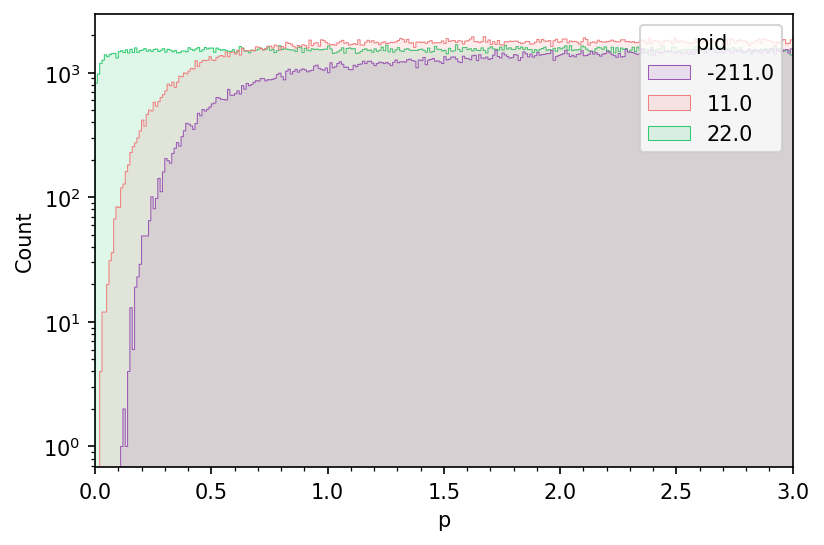

In [6]:
fig, ax = plt.subplots(dpi=150)
sns.histplot(sim_df, x="p", hue="pid", element="step", binwidth=.01, #weights=(sim_df["ShowerSum"]>0).astype(int), #"# rate",
             palette=sns.color_palette(best_colors[:-5]), alpha=0.15, linewidth=0.5)
plt.yscale("log")

plt.xlim(0,3)
ax.set_xticks(np.arange(0,3,.1), minor=1)
plt.show()

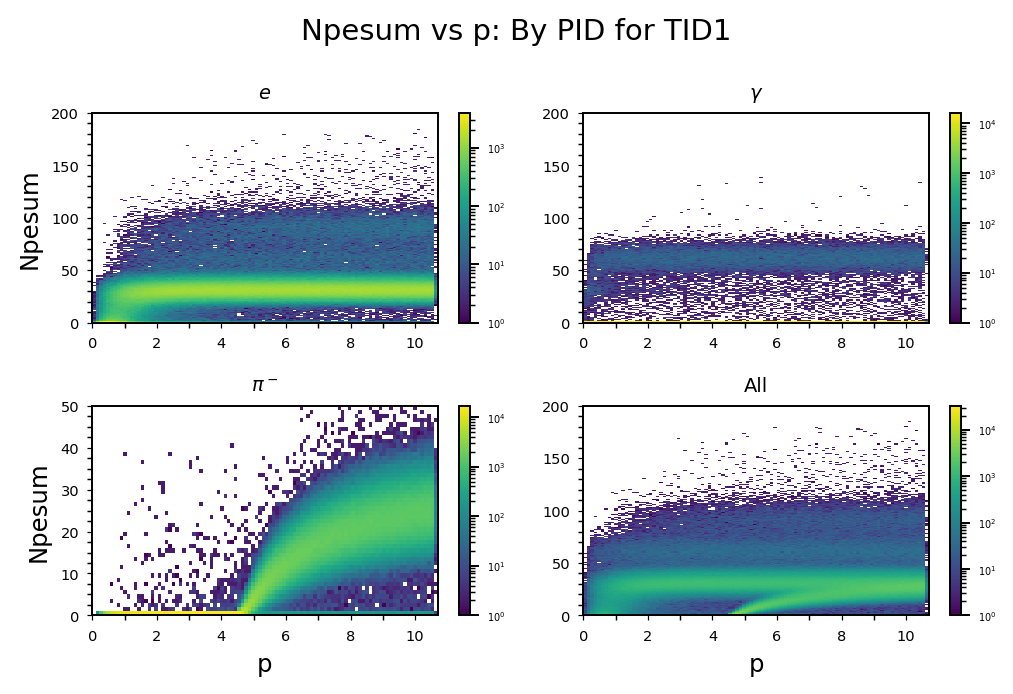

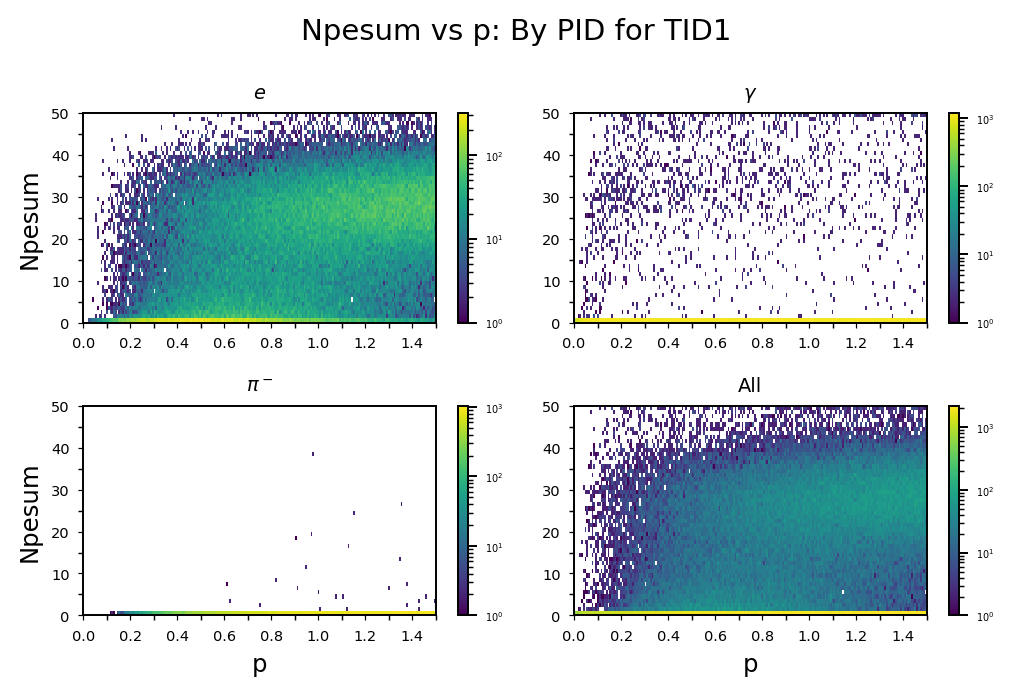

In [7]:
# Loop Over Shower Vals
columns =["p","Npesum"]
x_bin = [50, 5,5,5]

ylimits=[200,200,50,200]
y_ticks=[10,10,2.5,10]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Npesum vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]# & (all_sim["ShowerSum"]<30)]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((0,10.7),(0,ylimits[j])),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,ylimits[j]], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,11,1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut
plt.show()


# Loop Over Shower Vals
columns =["p","Npesum"]
x_bin = [50, 5,5,5]

ylimits=[200,200,50,200]
y_ticks=[10,10,2.5,10]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Npesum vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]# & (all_sim["ShowerSum"]<30)]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((0,1.5),(0,50)),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[200,50], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.51,.1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,51,5), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut
plt.show()




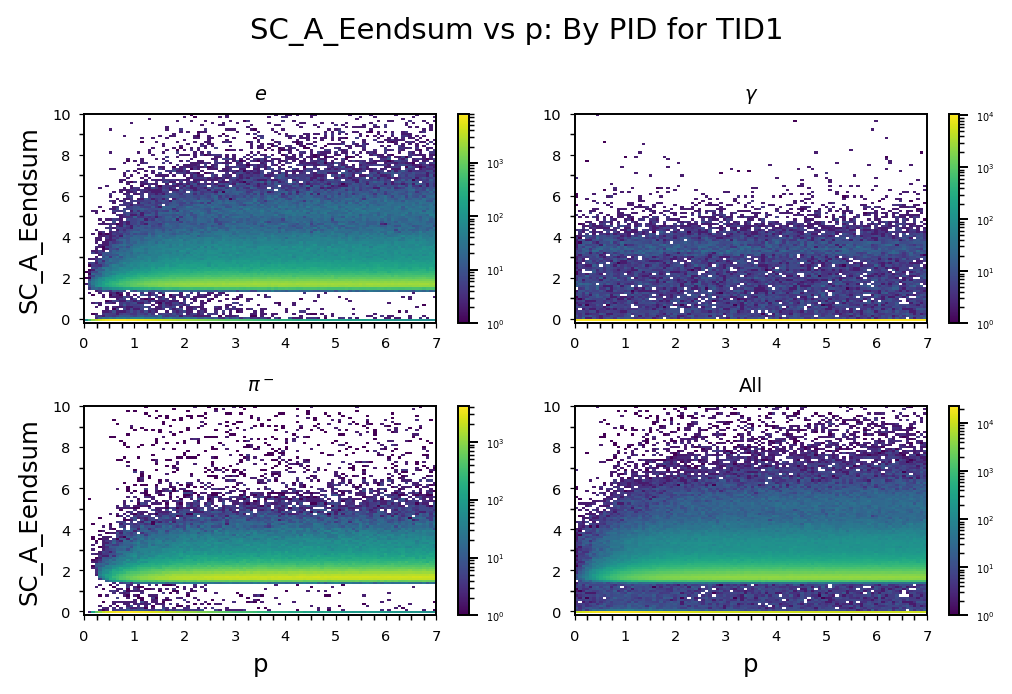

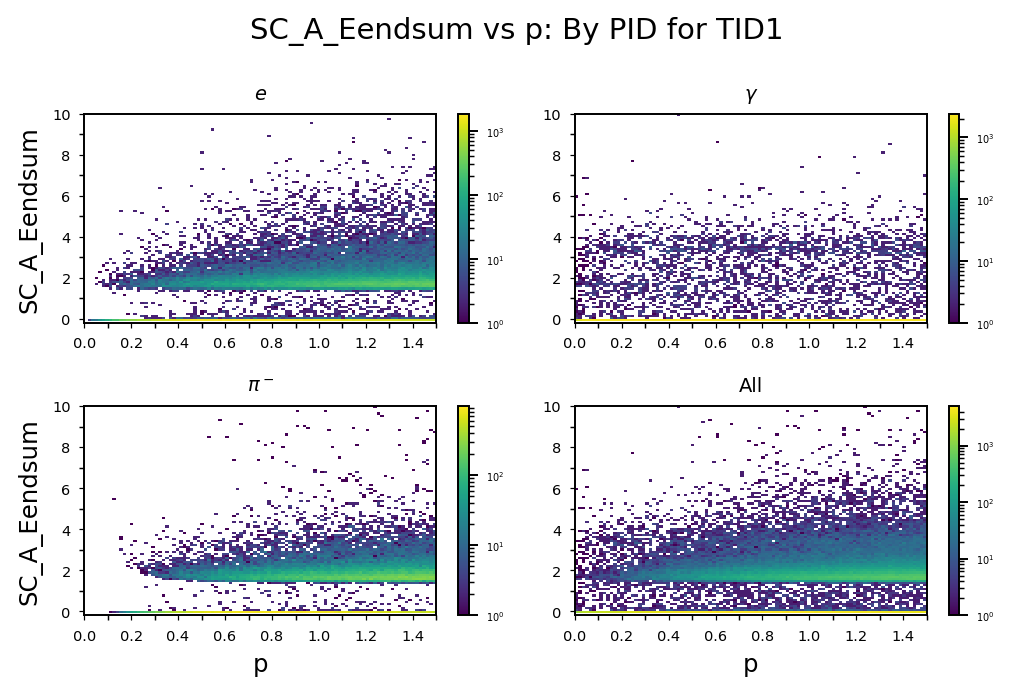

In [22]:
# Loop Over Shower Vals
columns =["p","SC_A_Eendsum"]
x_bin = [50, 5,5,5]

ylimits=[10,10,10,10]
y_ticks=[1,1,1,1]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle(f"{columns[1]} vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((0,7),(-.2,ylimits[j])),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,100], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,7.1,.25), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut
plt.show()


# Loop Over Shower Vals
columns =["p","SC_A_Eendsum"]
x_bin = [50, 5,5,5]

ylimits=[10,10,10,10]
y_ticks=[1,1,1,1]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle(f"{columns[1]} vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((0,1.5),(-.2,ylimits[j])),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,100], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.6,.1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut

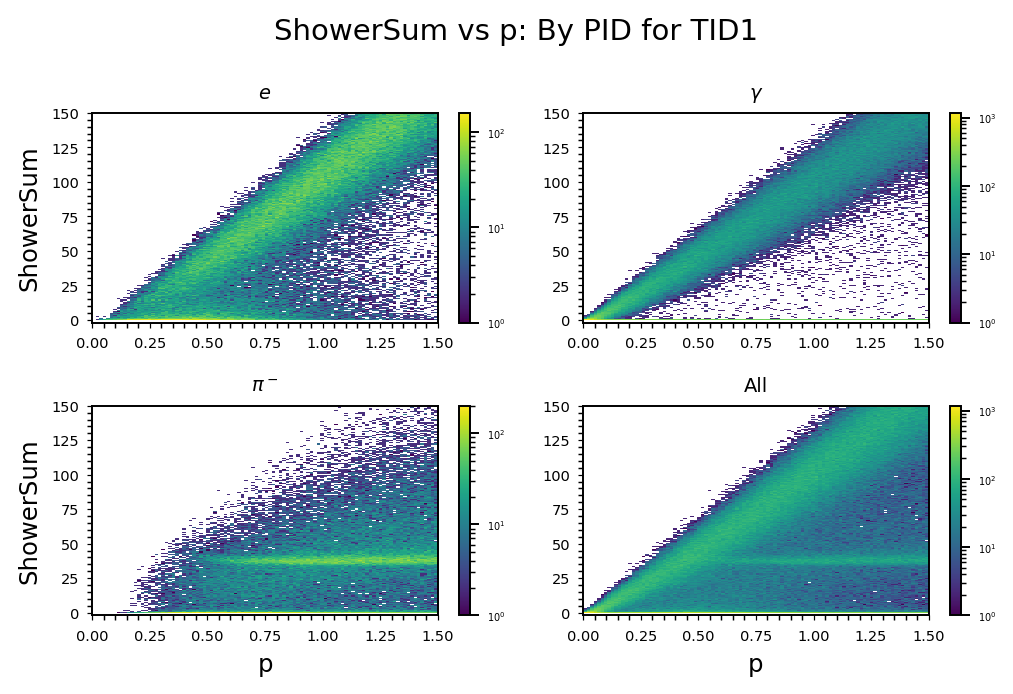

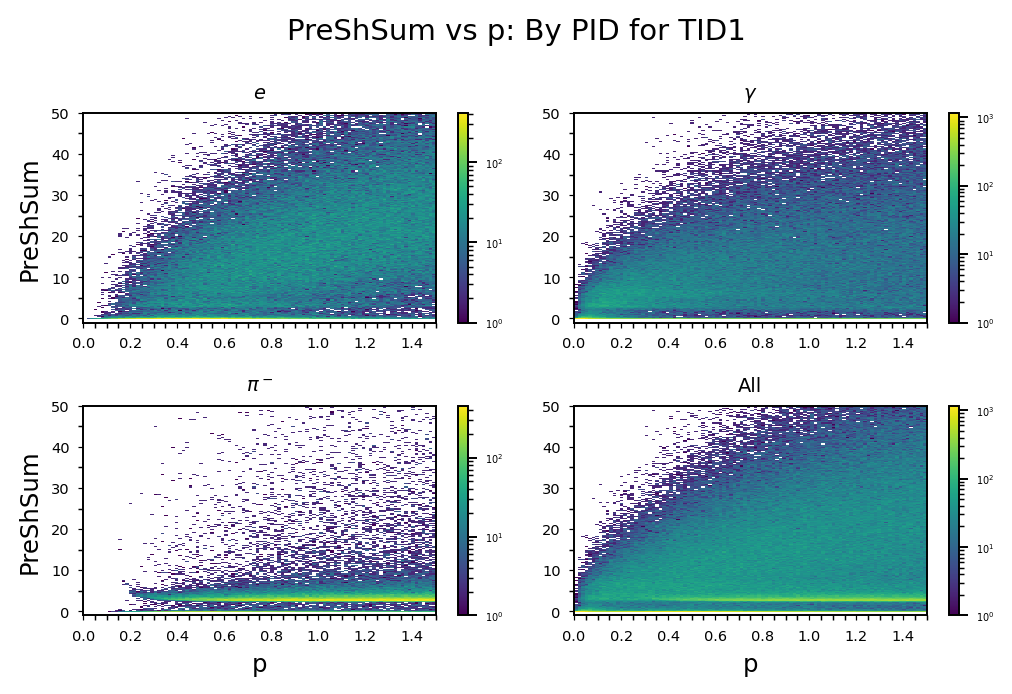

In [21]:
# Loop Over Shower Vals
columns =["p","ShowerSum"]
x_bin = [50, 5,5,5]

ylimits=[200,200,200,200]
y_ticks=[1,1,1,1]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle(f"{columns[1]} vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((0,1.5),(-2,150)),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,200], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.51,.05), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,150,5), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/Pencil_TID1_ShowerSum_Lowp.pdf")   #AngleCut
plt.show()


# Loop Over Shower Vals
columns =["p","PreShSum"]
x_bin = [50, 5,5,5]

ylimits=[50,50,50,50]
y_ticks=[1,1,1,1]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle(f"{columns[1]} vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((0,1.5),(-1,50)),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,200], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.51,.05), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,50,5), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/Pencil_TID1_PreShowerSum_Lowp.pdf")   #AngleCut


In [10]:
plt.figure(dpi=150)
plt.hist(X.sum(axis=1), bins=np.arange(0,200,1), alpha=0.2)
plt.hist((data*np.max(X)).sum(axis=1), bins=np.arange(0,200,1), alpha=0.2)
plt.hist((test_data*np.max(X)).sum(axis=1), bins=np.arange(0,200,1), alpha=0.2)

plt.yscale("log")

NameError: name 'X' is not defined

<Figure size 900x600 with 0 Axes>

# MLP

## Samples

In [ ]:
sim_df.columns[[-3,-1,8]]

In [ ]:
sns.histplot(sim_df[keeps],x="Npesum", hue="pid",  element="step", binwidth=1, #weights=(sim_df["ShowerSum"]>0).astype(int), #"# rate",
             palette=sns.color_palette(best_colors[:-6]), alpha=0.15, linewidth=0.5)
plt.yscale("log")

In [204]:
(sim_df["Npesum"][(keeps)][y==0]).sum()/(sim_df["Npesum"][keeps][y==0]).sum()

IndexError: Boolean index has wrong length: 158480 instead of 84193

In [4]:
%%time
#Number of background events per data event
n_bkg = 1#00

keeps = ((sim_df["pid"]==11) | ((sim_df["pid"]==111) & (sim_df["p"]<4.7))) & (sim_df["p"]<=1)
#keeps = ((sim_df["pid"]==11)|(sim_df["pid"]==-211)) & ((sim_df["p"]>0) & (sim_df["p"]<=.5))


#data_np = sim_cher[keeps].to_numpy() #Cher Channels
data_np = sim_df[keeps].to_numpy()
#bkg_np = ((raw_bkg_df.sample(n=n_bkg*len(data_np), random_state=42, replace=1)).to_numpy()).reshape((len(data_np),-1,len(raw_bkg_df.columns))).sum(axis=1)
cher_np = sim_cher[keeps].to_numpy()

#X = data_np[:,[0, 4,5,6,7, 15,16,17,18, 19,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5]] #with momentum #np.delete(data_np, np.arange(0,9,1), 1)
               #15, 19, 24,27,30,33, 39, 41,47,53,59, -2]]

#X = data_np[:,np.arange(0,16,1)]
X = data_np[:,[-3,-1]]
X_bkg = np.random.randint(0,1,size=(len(X),16))
#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]] #No clustering
#X_bkg = bkg_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -2,-1]]

#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5, -4,-3, -2,-1]] #With clustering
X_Cher = cher_np[:,np.arange(0,16,1)]

#Full_X = np.column_stack([X,X_Cher])

Full_X = X_Cher #+ X_bkg

#Get Labels
#y = data_np[:,-1].astype(int)
y = data_np[:,8].astype(int)
y[y==11] = 0
#y += np.round(np.random.uniform(0,1,len(y))).astype(int)
#y[y==22] = 0
#y[y==-211] = 1
y[y==111] = 1

scaler = MinMaxScaler()
#data = scaler.fit_transform(Full_X)
data = Full_X/np.max(Full_X)

# print(data.min(), data.max())

#train_data, test_data, train_labels, test_labels = train_test_split(data[:, :-1], data[:, -1], test_size=0.25, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(data, y, test_size=0.4, random_state=42)

print("Train:", len(train_data))
print("Test:", len(test_data))

Train: 63908
Test: 42606
CPU times: user 537 ms, sys: 780 ms, total: 1.32 s
Wall time: 1.24 s


## Model

In [5]:
model = tf.keras.Sequential([
    Input(data.shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               8704      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

2023-07-29 10:38:03.186235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-07-29 10:38:03.186281: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-29 10:38:03.186306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (farm180246.jlab.org): /proc/driver/nvidia/version does not exist
2023-07-29 10:38:03.186651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01) #10**-3 or 10**-4
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)


model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
              metrics=['accuracy'])#, electron_eff, pi_reject])

In [7]:
np.unique(train_labels)

array([0])

## Training

In [8]:
%%time

version = "SULI_Week9_Pencil_Cher"#VeryHighBkg_New" #With_Momentum" #_Momentum_ShSum_Cut"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.01, factor=0.9, patience=3, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6) #use 1e-4, 10
un_cts = np.unique(y, return_counts=1)

history = model.fit(train_data, train_labels, batch_size=500, epochs=50,
                    #class_weight = {int(un_cts[0][0]):1/un_cts[1][0], int(un_cts[0][1]):1/un_cts[1][1], int(un_cts[0][2]):1/un_cts[1][2]},
                    #{0:1.5, 1:30, 2:8}, #{0:10, 1:1, 2:10, 3:1}, #{0:1.5, 1:30, 2:8
                    #sample_weight = np.abs((train_labels-1.3)**-1),#train_labels,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(test_data, test_labels))


2023-07-29 10:38:56.447434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
128/128 [==============================] - 3s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
128/128 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/50
128/128 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/50
128/128 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/50
101/128 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

KeyboardInterrupt: 

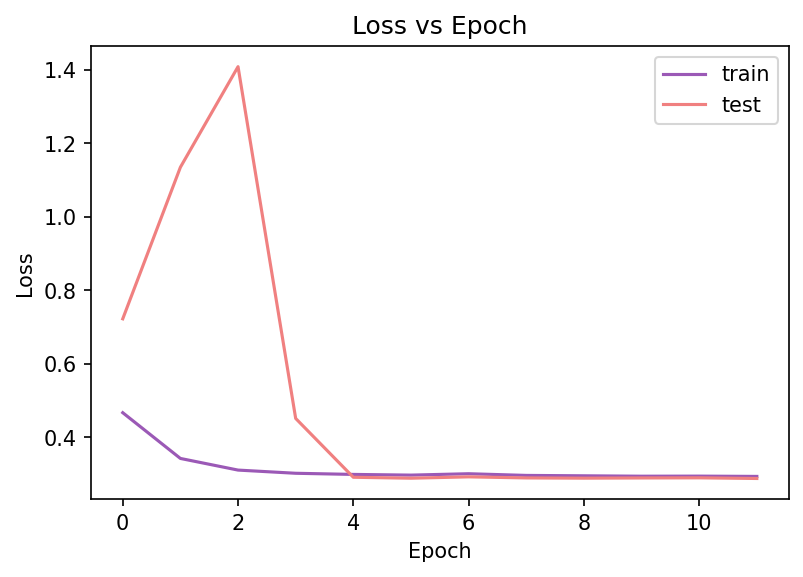

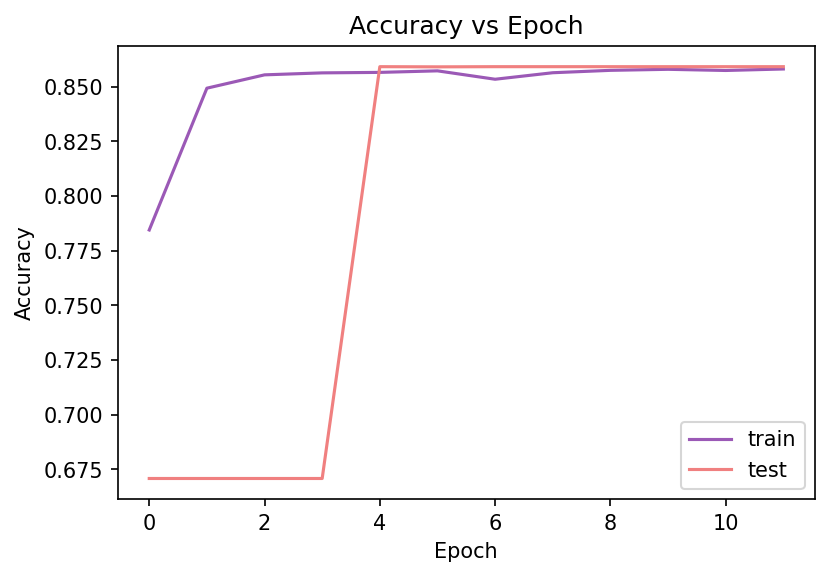

In [213]:
plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/TrainingPlots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/TrainingPlots/Sim_Accuracy_{version}.pdf")
plt.show()

## Confusion Matrices

CPU times: user 1.39 s, sys: 285 ms, total: 1.68 s
Wall time: 966 ms


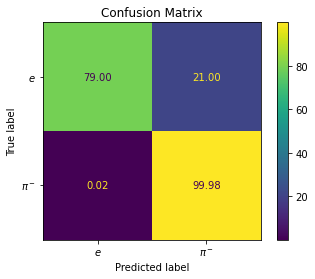

In [214]:
%%time

probability_model = model

predictions = probability_model.predict(test_data)
results = np.argmax(predictions, axis=1)

#e_eff = ((results==0)*(test_labels==0)).sum()/(test_labels==0).sum()
#pi_rej = 1-(((results==0)*(test_labels==2)).sum()/(test_labels==2).sum())

#print("e Efficiency:",e_eff)
#print("Pi Rejection:",pi_rej)

cm= confusion_matrix(test_labels,results)#, sample_weight=test_data[:,0])
cm_percent = (cm)/(np.repeat(cm.sum(axis=1),2,axis=0).reshape(2,2))*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,display_labels=["$e$","$\pi^-$"])#[11,22,211]) #"$\gamma$",
disp.plot(values_format='.2f')

plt.title(f"Confusion Matrix")#: $e$:{e_eff*100: .1f}% & $\pi$:{pi_rej*100: .1f}%")

plt.savefig(f"Plots/ConfusionPlots/Sim_Confusion_{version}.pdf")



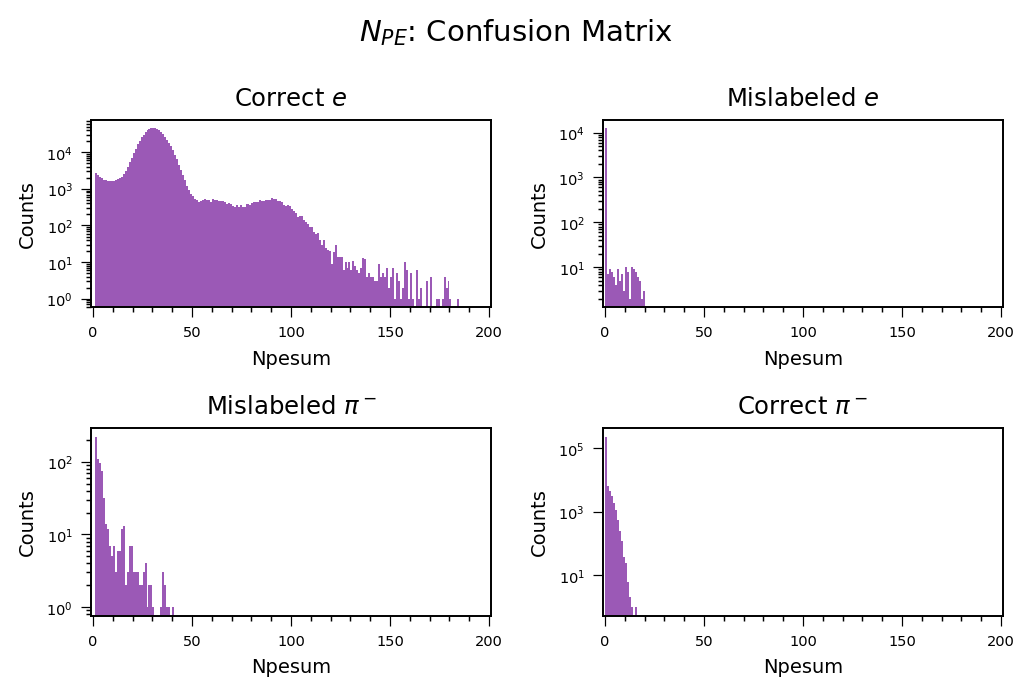

In [59]:
labels = ["Correct $e$", "Mislabeled $e$", "Mislabeled $\pi^-$", "Correct $\pi^-$"]    
    
fig, axes = plt.subplots(2, 2, dpi=175)    
plt.suptitle("$N_{PE}$: Confusion Matrix")

for j in range(4):

    #plt.subplot(2,2,i+1)
    axes[int(j/2),j%2].set_title(labels[j], fontsize=10)
    axes[int(j/2),j%2].set_xlabel("Npesum", fontsize=8)
    axes[int(j/2),j%2].set_ylabel("Counts", fontsize=8)

    keeps = (test_labels==int(j/2)) & (results==j%2)
    axes[int(j/2),j%2].hist((test_data*np.max(X)).sum(axis=1)[keeps], bins=np.arange(0,200,1))

    #cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    #cbar.ax.tick_params(labelsize=4)
    
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,50))#, fontsize=4)
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,10), minor=1)
    
    axes[int(j/2),j%2].set_xlim(-1,201)
    #axes[int(j/2),j%2].set_ylim(0,.5)
    
    axes[int(j/2),j%2].set_yscale("log")
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=4, width=0.5)

plt.tight_layout()
plt.savefig(f"Plots/ConfusionPlots/NPE_Confusion_{version}.pdf")

# CNN

## Samples

sim_df = pd.read_csv("Sim_CSV/Sim_Pencil_Sample500k.csv")

raw_sim_cher = pd.read_csv("Sim_CSV/Sim_CherChannels.csv", 
                           names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_sim_cher["pid"] = sim_df["pid"]

In [47]:
%%time
#sim_cher = raw_sim_cher
keeps = (sim_df["pid"]==11) | ((sim_df["pid"]==-211) & (sim_df["p"]<5))
data_np = (sim_cher[keeps]).to_numpy()

X = data_np[:,:16]
Full_X = X/np.max(X)

y = data_np[:,-1].astype(int)
y[y==11] = 0
#y += np.round(np.random.uniform(0,1,len(y))).astype(int)
#y[y==22] = 1
y[y==-211] = 1

cnn_train_data, cnn_test_data, cnn_train_labels, cnn_test_labels = train_test_split(Full_X, y, test_size=0.4, random_state=42)

cnn_train_data = cnn_train_data.reshape(-1, 4, 4, 1)
cnn_test_data = cnn_test_data.reshape(-1, 4, 4, 1)

print("Train:", len(cnn_train_data))
print("Test:", len(cnn_test_data))
print(np.unique(y, return_counts=1))

Train: 1474314
Test: 982877
(array([0, 1]), array([1819916,  637275]))
CPU times: user 966 ms, sys: 548 ms, total: 1.51 s
Wall time: 1.37 s


## Model

#Does work
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(16, (2,2), activation='relu', input_shape=(4,4,1)))
model_cnn.add(layers.MaxPooling2D(padding='same'))#(2, 2)))
model_cnn.add(layers.Conv2D(32, (2,2), activation='relu',padding='same'))#, input_shape=(4,4,1)))
#model_cnn.add(layers.MaxPooling2D(padding='same'))#(2, 2)))
#model_cnn.add(layers.Conv2D(16, (2,2), activation='relu', input_shape=(4,4,1)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(16, activation='relu'))
model_cnn.add(layers.Dense(3, activation="softmax"))

model_cnn.summary()

#Not work
model_cnn2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

#model_cnn2.summary()

In [48]:
model_cnn = models.Sequential([
    layers.Conv2D(32, (2,2), activation='relu', input_shape=(4,4,1)), 
    layers.MaxPooling2D(padding='same'), 
    layers.Conv2D(64, (2,2), activation='relu',padding='same'), 
    layers.MaxPooling2D(padding='same'), 
    layers.Conv2D(64, (2,2), activation='relu', padding="same"), 
    layers.MaxPooling2D(padding='same'), 
    layers.Dropout(0.2),
    layers.Flatten(), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(2, activation="softmax")
])
    
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 32)          160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 1, 64)         

In [53]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01) #10**-3 or 10**-4
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)


model_cnn.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
                  metrics=['accuracy'])#, electron_eff, pi_reject])

In [54]:
%%time

version = "SULI_Week2_Pencil_Cher_Channels_CNN_Full_epi"#VeryHighBkg_New" #With_Momentum" #_Momentum_ShSum_Cut"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.01, factor=0.8, patience=2, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6) #use 1e-4, 10
un_cts = np.unique(y, return_counts=1)

history = model_cnn.fit(cnn_train_data, cnn_train_labels, batch_size=2000, epochs=50,
                        #class_weight = {int(un_cts[0][0]):1/un_cts[1][0], int(un_cts[0][1]):1/un_cts[1][1]}, #int(un_cts[0][2]):1/un_cts[1][2]},
                        #{0:1.5, 1:30, 2:8}, #{0:10, 1:1, 2:10, 3:1}, #{0:1.5, 1:30, 2:8
                        #sample_weight = np.abs((train_labels-1.3)**-1),#train_labels,
                        callbacks=[reduce_lr,early_stop],
                        validation_data=(cnn_test_data, cnn_test_labels))


Epoch 1/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0559 - accuracy: 0.9862 - val_loss: 0.0546 - val_accuracy: 0.9864
Epoch 2/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0548 - accuracy: 0.9864 - val_loss: 0.0546 - val_accuracy: 0.9864
Epoch 3/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0545 - accuracy: 0.9864 - val_loss: 0.0542 - val_accuracy: 0.9865
Epoch 4/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0542 - accuracy: 0.9865 - val_loss: 0.0542 - val_accuracy: 0.9865
Epoch 5/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0542 - accuracy: 0.9865 - val_loss: 0.0541 - val_accuracy: 0.9865
Epoch 6/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0541 - accuracy: 0.9865 - val_loss: 0.0540 - val_accuracy: 0.9865
Epoch 7/50
738/738 [==============================] - 7s 9ms/step - loss: 0.0541 - accuracy: 0.9865 - val_loss: 0.0540 - val_accuracy: 0.9865
CPU ti

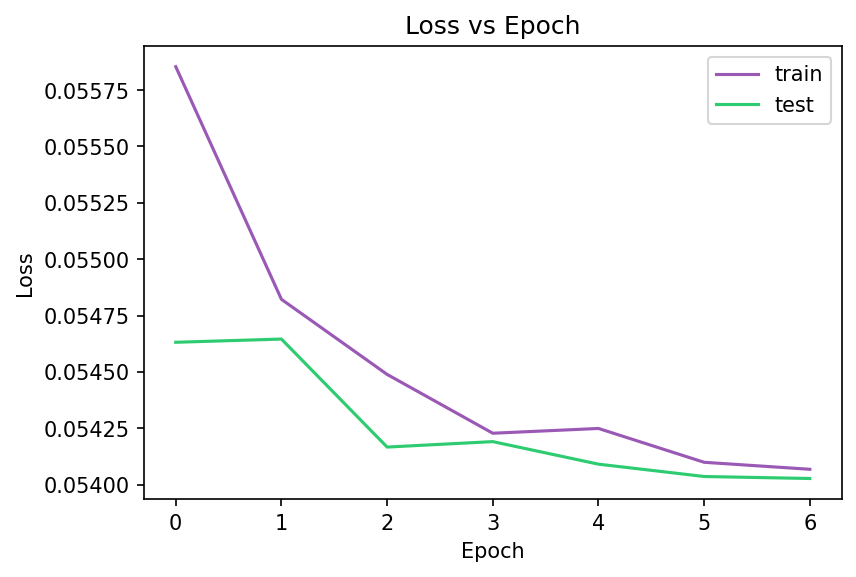

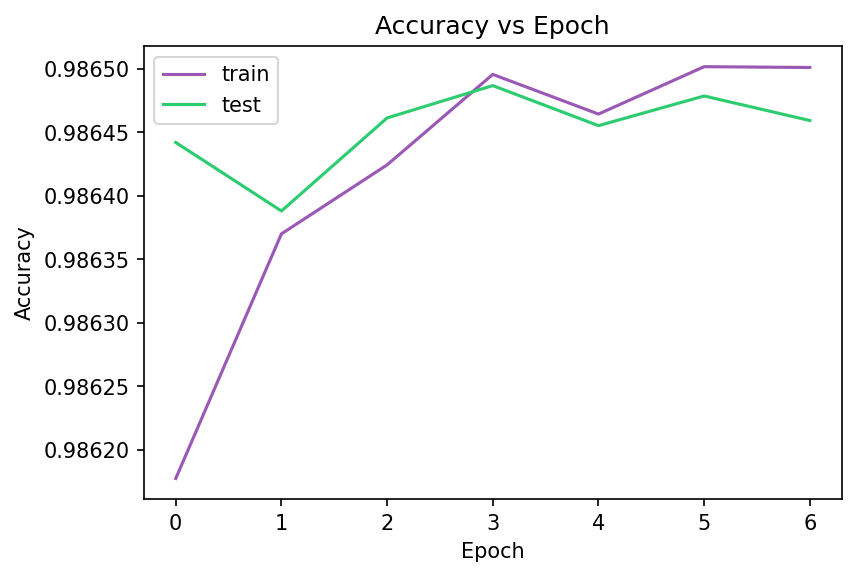

CPU times: user 534 ms, sys: 482 ms, total: 1.02 s
Wall time: 364 ms


In [55]:
%%time

version = "SULI_Week2_Pencil_Cher_Channels_CNN_Full_epi"

plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/TrainingPlots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/TrainingPlots/Sim_Accuracy_{version}.pdf")
plt.show()

## Confusion Matrices

CPU times: user 25.5 s, sys: 5.61 s, total: 31.1 s
Wall time: 15.7 s


<Figure size 900x600 with 0 Axes>

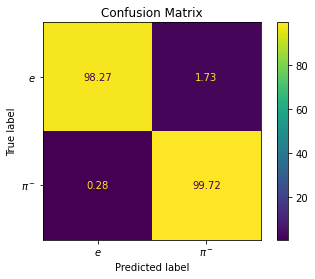

In [60]:
%%time

probability_model = model_cnn

predictions = probability_model.predict(cnn_test_data)
results = np.argmax(predictions, axis=1)

#e_eff = ((results==0)*(test_labels==0)).sum()/(test_labels==0).sum()
#pi_rej = 1-(((results==0)*(test_labels==2)).sum()/(test_labels==2).sum())

#print("e Efficiency:",e_eff)
#print("Pi Rejection:",pi_rej)

cm = confusion_matrix(cnn_test_labels,results)#, sample_weight=test_data[:,0])
#cm_percent = (cm)/(np.repeat(cm.sum(axis=1),3,axis=0).reshape(3,3))*100
cm_percent = (cm)/(np.repeat(cm.sum(axis=1),2,axis=0).reshape(2,2))*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,display_labels=["$e$","$\pi^-$"])
#["$e$","$\gamma$","$\pi^+$"])#[11,22,211])

plt.figure(dpi=150)
disp.plot(values_format='.2f')

plt.title(f"Confusion Matrix")#: $e$:{e_eff*100: .1f}% & $\pi$:{pi_rej*100: .1f}%")

plt.savefig(f"Plots/ConfusionPlots/Sim_Confusion_{version}.pdf")



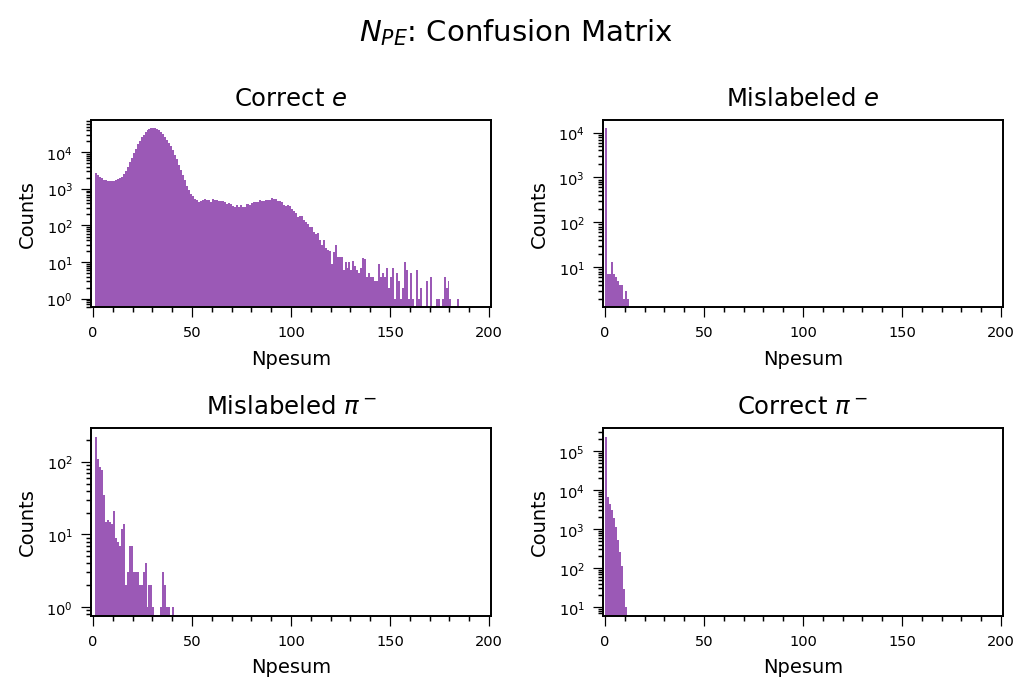

In [61]:
labels = ["Correct $e$", "Mislabeled $e$", "Mislabeled $\pi^-$", "Correct $\pi^-$"]    
    
fig, axes = plt.subplots(2, 2, dpi=175)    
plt.suptitle("$N_{PE}$: Confusion Matrix")

for j in range(4):

    #plt.subplot(2,2,i+1)
    axes[int(j/2),j%2].set_title(labels[j], fontsize=10)
    axes[int(j/2),j%2].set_xlabel("Npesum", fontsize=8)
    axes[int(j/2),j%2].set_ylabel("Counts", fontsize=8)

    keeps = (test_labels==int(j/2)) & (results==j%2)
    axes[int(j/2),j%2].hist((test_data*np.max(X)).sum(axis=1)[keeps], bins=np.arange(0,200,1))

    #cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    #cbar.ax.tick_params(labelsize=4)
    
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,50))#, fontsize=4)
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,10), minor=1)
    
    axes[int(j/2),j%2].set_xlim(-1,201)
    #axes[int(j/2),j%2].set_ylim(0,.5)
    
    axes[int(j/2),j%2].set_yscale("log")
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=4, width=0.5)

plt.tight_layout()
plt.savefig(f"Plots/ConfusionPlots/NPE_Confusion_{version}.pdf")

# Comparing Results

In [19]:
%%time 
cl_true_e, cl_false_e = [], []

for cut_val in np.arange(1,61, 1):
    cl_true_e.append(((sim_df[(sim_df["pid"]==11)]["Npesum"]>cut_val)).mean())
    cl_false_e.append(((sim_df[(sim_df["pid"]==-211)]["Npesum"]<cut_val)).mean())
    
    if cut_val%5==0: print(cut_val)
    
cl_true_e, cl_false_e = np.array(cl_true_e), np.array(cl_false_e)

5
10
15
20
25
30
35
40
45
50
55
60
CPU times: user 45.9 s, sys: 1min 54s, total: 2min 40s
Wall time: 2min 35s


In [22]:
len(n_e)

200

In [23]:
%%time 
cl_true_e_2D, cl_false_e_2D = [], []

keeps_e = ((sim_df["Npesum"]>0) &(sim_df["pid"]==11))
keeps_pi = ((sim_df["Npesum"]>0) &(sim_df["pid"]==-211))

for b in np.arange(4,8.001,2):
    for m in np.arange(-.08,.0801,.04):
        #print(m,b)
        cut_vals_e = m*sim_df[keeps_e]["Npesum"] + b
        cut_vals_pi = m*sim_df[keeps_pi]["Npesum"] + b
        
        cl_true_e_2D.append(((sim_df[keeps_e]["NCh"]>cut_vals_e)).mean())
        cl_false_e_2D.append(((sim_df[keeps_pi]["NCh"]<cut_vals_pi)).mean())
    
cl_true_e_2D, cl_false_e_2D = np.array(cl_true_e_2D), np.array(cl_false_e_2D)

CPU times: user 22 s, sys: 51.5 s, total: 1min 13s
Wall time: 1min 13s


In [22]:
%%time
N_PEs = cnn_test_data.sum(axis=(1,2))
N_CHs = (cnn_test_data>0).sum(axis=(1,2))
#cnn_test_labels


keeps_e = (cnn_test_labels==0)
keeps_pi = (cnn_test_labels==1)

cl_true_e_2D, cl_false_e_2D = [], []

for b in np.arange(2,8.001,.05):
    for m in np.arange(-1,1,.01):
        pred_clas_2D = (N_CHs < (m*N_PEs + b))
        #print(m,b,pred_clas_2D.sum())
        
        cl_true_e_2D.append(((pred_clas_2D[keeps_e]==0)).mean())
        cl_false_e_2D.append(((pred_clas_2D[keeps_pi]==1)).mean())
    
cl_true_e_2D, cl_false_e_2D = np.array(cl_true_e_2D), np.array(cl_false_e_2D)

KeyboardInterrupt: 

In [ ]:
len(cl_true_e_2D)

In [ ]:
plt.scatter(cl_false_e_2D,cl_true_e_2D)

In [ ]:
(sim_df[keeps_e]["NCh"]>cut_vals_e).sum()

In [ ]:
cl_true_e_2D

In [ ]:
plt.figure(dpi=150)

plt.plot(cl_false_e, cl_true_e)

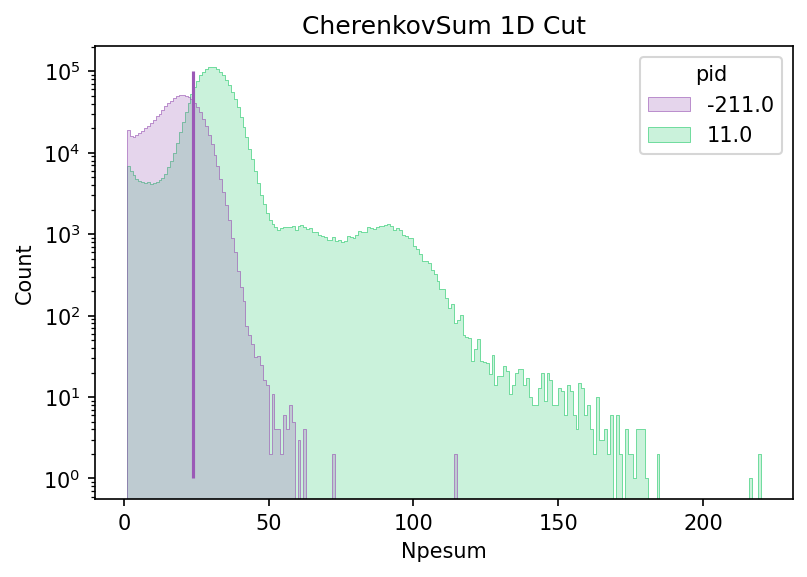

In [24]:
plt.figure(dpi=150)
plt.title("CherenkovSum 1D Cut")
sns.histplot(sim_df[(sim_df["Npesum"]>0)&(sim_df["pid"]!=22)], x="Npesum", hue="pid", binwidth=1, element="step", 
             palette=sns.color_palette(best_colors[:-2]), alpha=0.25, linewidth=0.3)
plt.vlines(24,1,10**5)
plt.yscale("log")
plt.savefig("Plots/Sim_Pencil_1DCherCut.pdf")

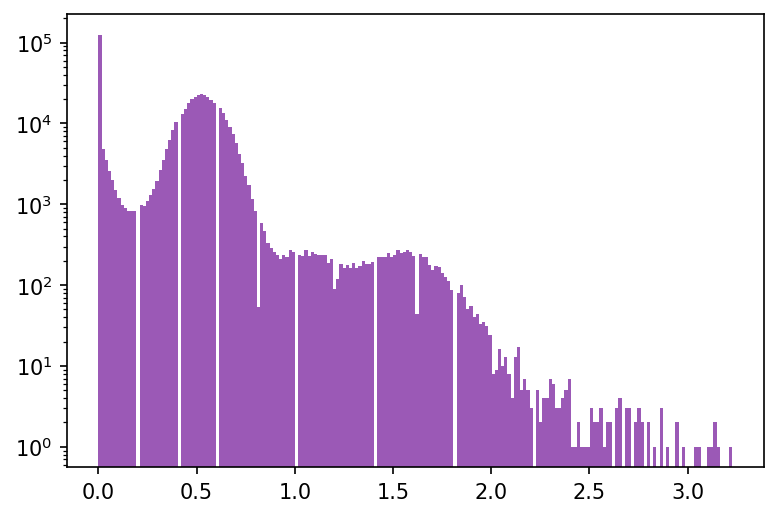

In [25]:
plt.figure(dpi=150)

plt.hist(cnn_test_data.reshape(-1,16).sum(axis=1),bins=200)
plt.yscale("log")

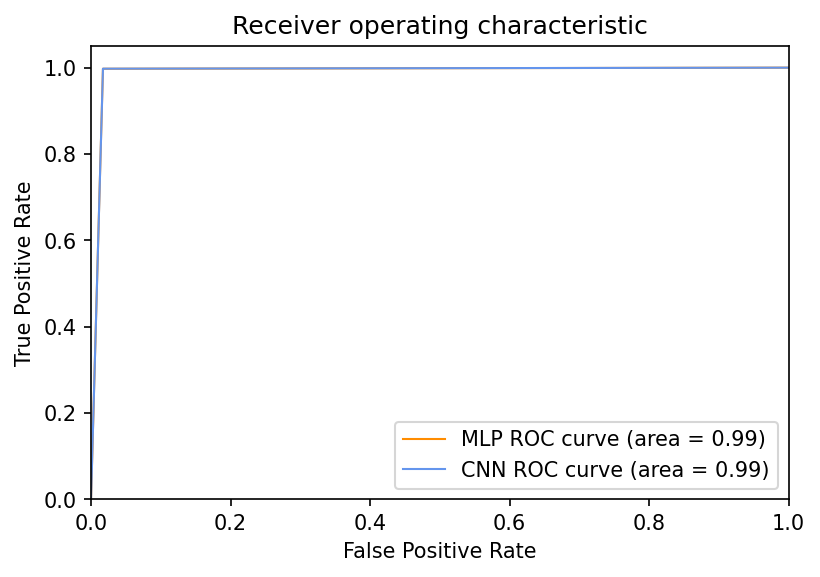

CPU times: user 51.4 s, sys: 8.51 s, total: 60 s
Wall time: 24.7 s


In [26]:
%%time

pred_labels = np.argmax(model.predict(cnn_test_data.reshape(-1,16)), axis=1)#.ravel()
fpr_roc, tpr_roc, thresholds_roc = roc_curve(cnn_test_labels, pred_labels)
roc_auc = auc(fpr_roc, tpr_roc)

pred_labels_cnn = np.argmax(model_cnn.predict(cnn_test_data), axis=1)#.ravel()
fpr_roc_cnn, tpr_roc_cnn, thresholds_roc_cnn = roc_curve(cnn_test_labels, pred_labels_cnn)
roc_auc_cnn = auc(fpr_roc_cnn, tpr_roc_cnn)
 
plt.figure(dpi=150)
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=1, label='MLP ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_roc_cnn, tpr_roc_cnn, color='cornflowerblue', lw=1, label='CNN ROC curve (area = %0.2f)' % roc_auc_cnn)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [27]:
%%time
mlp_predictions = model.predict(cnn_test_data.reshape(-1,16))
cnn_predictions = model_cnn.predict(cnn_test_data)


CPU times: user 54.3 s, sys: 8.38 s, total: 1min 2s
Wall time: 25.4 s


In [42]:
%%time

prob_limits = np.arange(0.4,1.01,.0002)

mlp_true_e, mlp_false_e = [], []
cnn_true_e, cnn_false_e = [], []

for p_val in prob_limits:
    mlp_pids = mlp_predictions[:,0]>p_val
    cnn_pids = cnn_predictions[:,0]>p_val
    
    mlp_true_e.append(((mlp_pids==0)*(cnn_test_labels==0)).sum()/(cnn_test_labels==0).sum())
    mlp_false_e.append(((mlp_pids==0)*(cnn_test_labels==1)).sum()/(cnn_test_labels==1).sum())
    
    cnn_true_e.append(((cnn_pids==0)*(cnn_test_labels==0)).sum()/(cnn_test_labels==0).sum())
    cnn_false_e.append(((cnn_pids==0)*(cnn_test_labels==1)).sum()/(cnn_test_labels==1).sum())
    
mlp_true_e, mlp_false_e = np.array(mlp_true_e), np.array(mlp_false_e)
cnn_true_e, cnn_false_e = np.array(cnn_true_e), np.array(cnn_false_e)

CPU times: user 21.4 s, sys: 357 ms, total: 21.8 s
Wall time: 21.8 s


In [31]:
from scipy.integrate import simpson, trapezoid, romb

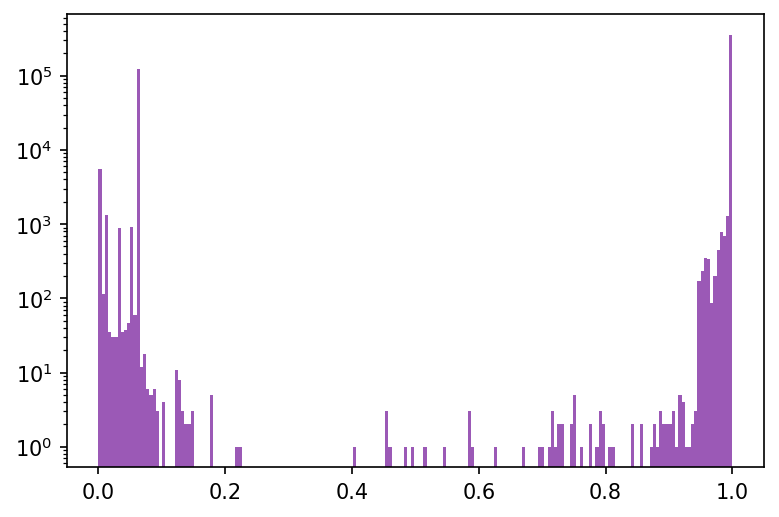

In [41]:
plt.figure(dpi=150)
plt.hist(mlp_predictions[:,0], bins=np.linspace(0,1,200))

plt.yscale("log")

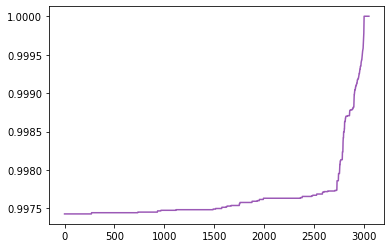

In [43]:
plt.plot(mlp_false_e)

In [34]:
simpson(mlp_true_e)/len(mlp_true_e)

0.025547894425460446

In [35]:
np.array([False] + list(np.diff(mlp_false_e)>0))

array([False,  True,  True, ..., False, False, False])

In [36]:
trapezoid(x=mlp_false_e, y=1-mlp_true_e)

0.9918675413199222

In [37]:
simpson(x=mlp_false_e[np.array([False] + list(np.diff(mlp_false_e)>0))], y=(1-mlp_true_e)[np.array([False] + list(np.diff(mlp_false_e)>0))])
#simpson(x=cnn_false_e, y=cnn_true_e)

0.9518142940367439

## Comparison Plots

/opt/conda/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:414: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/opt/conda/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:416: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1] * (hsum * hsum / hprod) +
/opt/conda/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:415: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0] * (2 - 1.0/h0divh1) +


[]

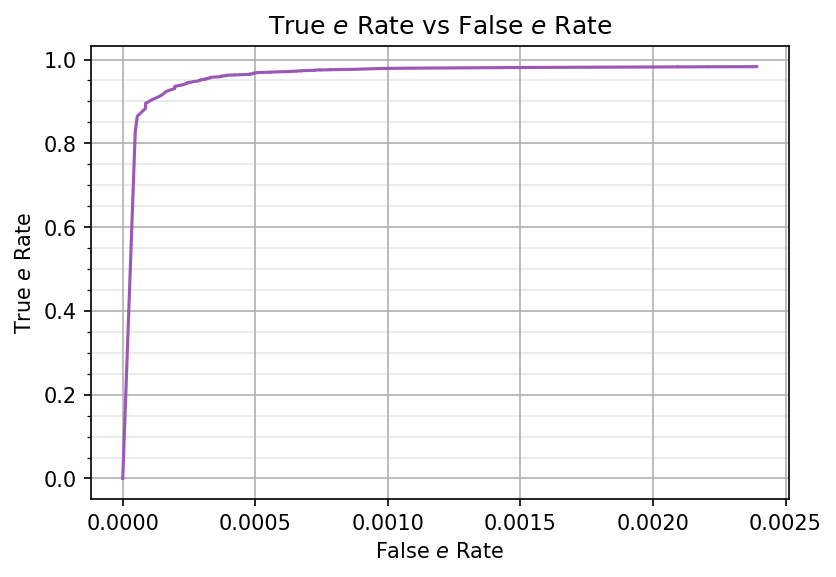

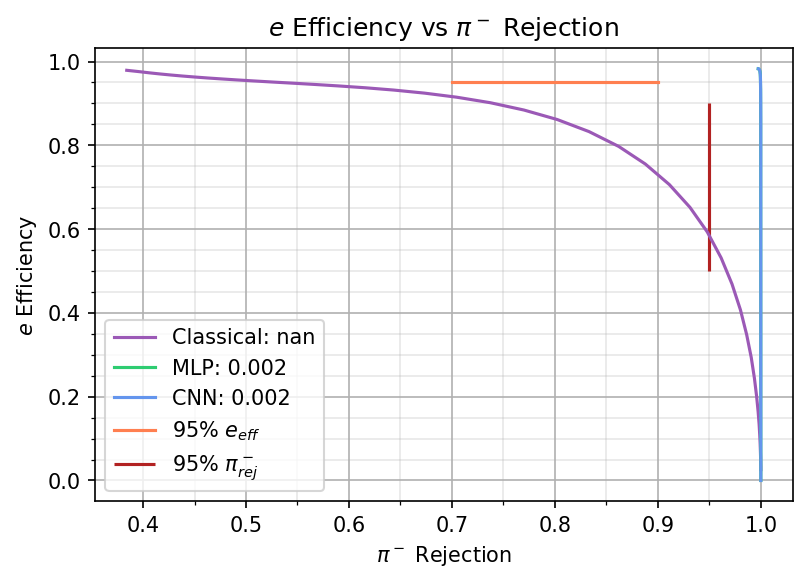

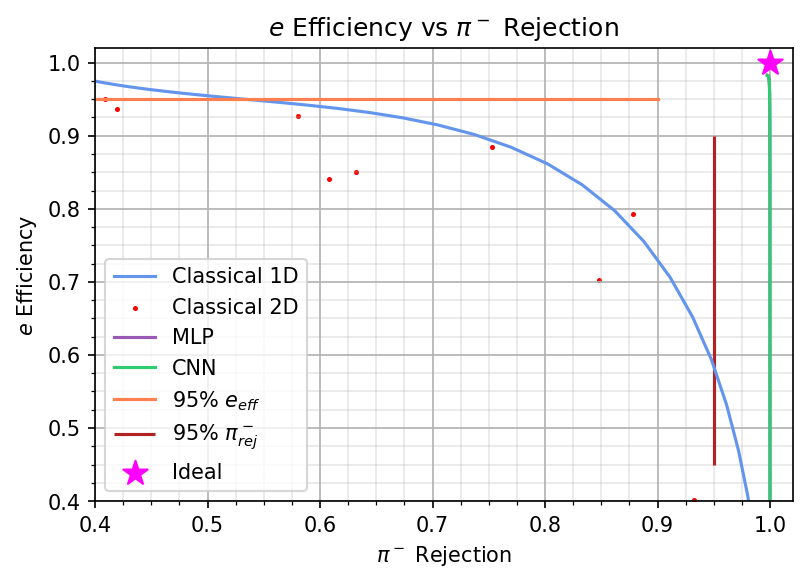

In [44]:
fig, ax = plt.subplots(dpi=150)
plt.title("True $e$ Rate vs False $e$ Rate")
plt.xlabel("False $e$ Rate")
plt.ylabel("True $e$ Rate")

plt.plot(1-cnn_false_e,1-cnn_true_e)

ax.set_xticks(np.arange(0,1.01,.05), minor=1)
ax.set_yticks(np.arange(0,1.01,.05), minor=1)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)
plt.plot()

##################################################################################################################
fig, ax = plt.subplots(dpi=150)
plt.title("$e$ Efficiency vs $\pi^-$ Rejection")
plt.ylabel("$e$ Efficiency")
plt.xlabel("$\pi^-$ Rejection")

plt.plot(cl_false_e, cl_true_e, label=f"Classical: {simpson(x=cl_false_e, y=cl_true_e):.3f}")
plt.plot(mlp_false_e,1-mlp_true_e, label=f"MLP: {trapezoid(x=mlp_false_e, y=1-mlp_true_e):.3f}")
plt.plot(cnn_false_e,1-cnn_true_e, label=f"CNN: {trapezoid(x=cnn_false_e, y=1-cnn_true_e):.3f}")

plt.vlines(0.95, .5,.9, color="firebrick", label="95% $\pi^-_{rej}$")
plt.plot([0.7,.9], [.95,.95], c="coral", label="95% $e_{eff}$")

plt.legend()

ax.set_xticks(np.arange(0,1.01,.05), minor=1)
ax.set_yticks(np.arange(0,1.01,.05), minor=1)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)
plt.savefig("Plots/ModelCompare_eEff_PiRej_ClassMLPCNN.pdf")
plt.plot()

##################################################################################################################
fig, ax = plt.subplots(dpi=150)
plt.title("$e$ Efficiency vs $\pi^-$ Rejection")
plt.ylabel("$e$ Efficiency")
plt.xlabel("$\pi^-$ Rejection")

plt.plot(mlp_false_e,1-mlp_true_e, label="MLP")
plt.plot(cnn_false_e,1-cnn_true_e, label="CNN")
plt.plot(cl_false_e, cl_true_e, label="Classical 1D")
plt.scatter(cl_false_e_2D,cl_true_e_2D,color="red",s=2, label="Classical 2D")


plt.vlines(0.95, .45,.9, color="firebrick", label="95% $\pi^-_{rej}$")
plt.plot([0.4,.9], [.95,.95], c="coral", label="95% $e_{eff}$")
plt.scatter(1,1, marker="*",s=150,c="magenta",zorder=100,label="Ideal")

#plt.plot([0,1],[1,0])

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2,4,0,1,3,5,6]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax.set_xticks(np.arange(0,1.025,.025), minor=1)
ax.set_yticks(np.arange(0,1.025,.025), minor=1)

plt.xlim(.4,1.02)
plt.ylim(.4,1.02)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)
plt.savefig("Plots/ModelCompare_eEff_PiRej_ClassMLPCNN_Zoom_Updated.pdf")
plt.plot()

## Updated Comparison

In [6]:
%%time 
cl_true_e, cl_pi_rej = [], []

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))

true_electrons = sim_df[(sim_df["pid"]==11) & (TS3_req)]
true_pim = sim_df[((sim_df["pid"]==-211) & (sim_df["p"]<5)) & (TS3_req)]

num_e, num_pim = len(true_electrons), len(true_pim)

for cut_val in np.arange(0,81, 1):
    cl_true_e.append((((true_electrons["Npesum"]>cut_val)).sum())/num_e)
    cl_pi_rej.append((((true_pim["Npesum"]<cut_val)).sum())/num_pim)
    
    if cut_val%10==0: print(cut_val)
    
cl_true_e, cl_pi_rej = np.array(cl_true_e), np.array(cl_pi_rej)

0
10
20
30
40
50
60
70
80
CPU times: user 1.24 s, sys: 910 ms, total: 2.15 s
Wall time: 1.37 s


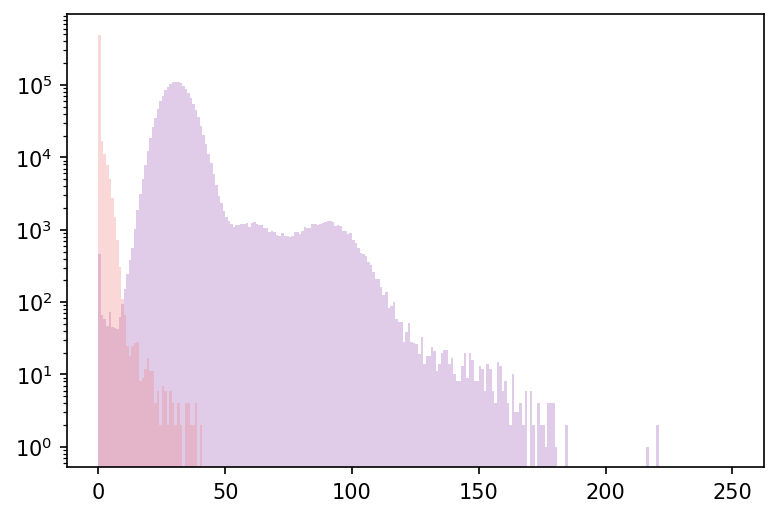

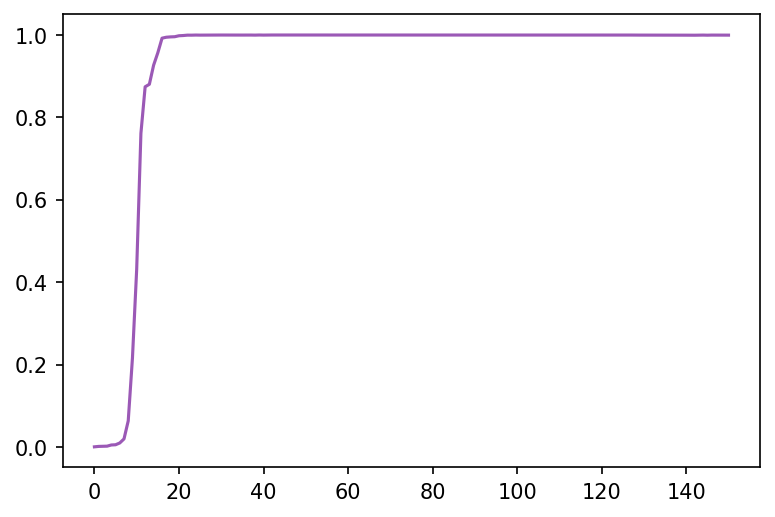

In [7]:
plt.figure(dpi=150)
Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))
Prob_1D_labels = sim_df["pid"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_1D_NPE = sim_df["Npesum"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_1D_labels[Prob_1D_labels==11] = 0
Prob_1D_labels[Prob_1D_labels==-211] = 1

n_e,bins_e, _ = plt.hist(sim_df["Npesum"][(sim_df["pid"]==11)&(TS3_req)], alpha=0.3, bins=np.arange(0,251,1))
n_pi,bins_pi, _ = plt.hist(sim_df["Npesum"][(sim_df["pid"]==-211)&(TS3_req)&(sim_df["p"]<5)], alpha=0.3, bins=np.arange(0,251,1))

plt.yscale("log")
plt.show()

plt.figure(dpi=150)
plt.plot(bins_e[:-100], ((n_e/n_e.sum())/(((n_pi+.001)/n_pi.sum()) + ((n_e+.001)/n_e.sum())))[:-99])


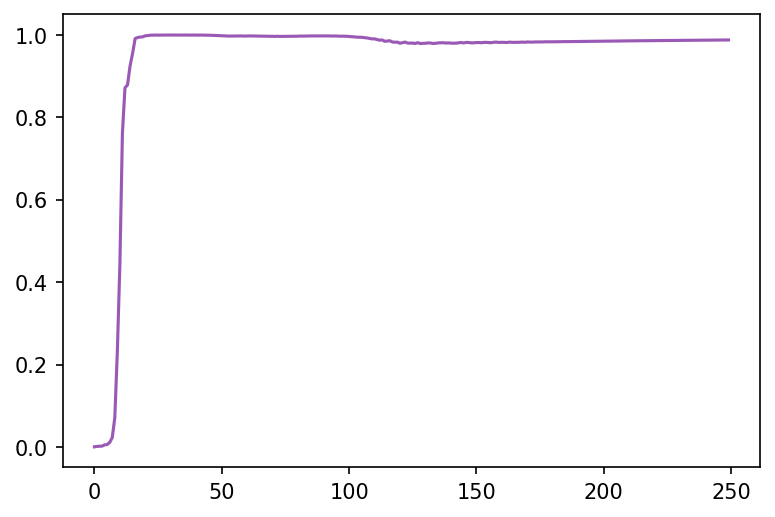

In [9]:
raw_density = np.column_stack([((n_e+bins_e[:-1])/n_e.sum()), ((n_pi+1)/n_pi.sum())])
prob_vals = (raw_density/(raw_density.sum(axis=1)[:,None]))
Prob_1D_probs = prob_vals

plt.figure(dpi=150)
#plt.hist(prob_vals[:,0], bins=np.arange(0,1.0001,.025), histtype="stepfilled", alpha=0.3)
plt.plot(prob_vals[:,0])
#plt.yscale("log")

array([[9.99903284e-01, 9.67156196e-05],
       [9.99803591e-01, 1.96408988e-04],
       [9.99658610e-01, 3.41390146e-04],
       ...,
       [3.10049873e-04, 9.99689950e-01],
       [3.10049873e-04, 9.99689950e-01],
       [3.10049873e-04, 9.99689950e-01]])

In [44]:
def get_eff_rej(predictions, test_labels, e_pid=0, intervals=1000, low_lim=0.4):
    spacing = .0001
    #prob_limits = np.arange(.40,1, spacing)
    prob_limits = np.unique(np.round(predictions[:,0],4)) #np.linspace(low_lim,1, int(intervals))
    #prob_limits = np.logspace(-.5,0, int(3e4))
    
    #Get Events
    e_events = (test_labels==e_pid)
    pi_events = (test_labels!=e_pid)
    
    #Get Nums
    num_e = (test_labels==e_pid).sum()
    num_pi = (test_labels!=e_pid).sum()

    true_e, false_e = [], []
    for p_val in prob_limits:
        pids = predictions[:,0]>p_val

        true_e.append(((pids==e_pid)*e_events).sum()/num_e)
        false_e.append(((pids==e_pid)*pi_events).sum()/num_pi)
    
    return np.array(true_e), np.array(false_e)

#GeV6_true_e, GeV6_false_e = get_eff_rej(GeV6_predictions, test_labels)

In [62]:
%%time

MLP_predictions = model.predict(test_data)
#CNN_predictions = model_cnn.predict(cnn_test_data)
#All_predictions = model_All.predict(test_data[:,1:])
#baseline_predictions = model_baseline.predict(test_data[:,1:])



CPU times: user 4.98 s, sys: 634 ms, total: 5.62 s
Wall time: 2.06 s


In [42]:
%%time
#full_predictions = full_model.predict(test_data)
#MLP_true_e, MLP_false_e = get_eff_rej(MLP_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_MLP_full.out', np.column_stack([MLP_true_e, MLP_false_e]), delimiter=',')

#full_predictions = full_model.predict(test_data)
#CNN_true_e, CNN_false_e = get_eff_rej(CNN_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_CNN_full.out', np.column_stack([CNN_true_e, CNN_false_e]), delimiter=',')

#MLP_NPE_predictions = model.predict(test_data)
#MLP_NPE_true_e, MLP_NPE_false_e = get_eff_rej(MLP_NPE_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_MLP_NPE.out', np.column_stack([MLP_NPE_true_e, MLP_NPE_false_e]), delimiter=',')

Prob_1D_predictions = Prob_1D_probs[Prob_1D_NPE.astype(int).values]
Prob_1D_true_e, Prob_1D_false_e = get_eff_rej(Prob_1D_predictions, Prob_1D_labels, intervals=1e3, low_lim=.01)


##For Momentum Slices
#GeV05_predictions = mom_05GeV.predict(test_data[:,1:])
#GeV05_true_e, GeV05_false_e = get_eff_rej(GeV05_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV05.out', np.column_stack([GeV05_true_e, GeV05_false_e]), delimiter=',')
#GeV05_true_e, GeV05_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV05.out", delimiter=","),2)

#GeV10_predictions = mom_10GeV.predict(test_data[:,1:])
#GeV10_true_e, GeV10_false_e = get_eff_rej(GeV10_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV10.out', np.column_stack([GeV10_true_e, GeV10_false_e]), delimiter=',')
#GeV10_true_e, GeV10_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV10.out", delimiter=","),2)

#GeV15_predictions = mom_15GeV.predict(test_data[:,1:])
#GeV15_true_e, GeV15_false_e = get_eff_rej(GeV15_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV15.out', np.column_stack([GeV15_true_e, GeV15_false_e]), delimiter=',')
#GeV15_true_e, GeV15_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV15.out", delimiter=","),2)

#GeV20_predictions = mom_20.predict(test_data[:,1:])
#GeV20_true_e, GeV20_false_e = get_eff_rej(GeV20_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV20.out', np.column_stack([GeV20_true_e, GeV20_false_e]), delimiter=',')
#GeV20_true_e, GeV20_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV20.out", delimiter=","),2)

#GeV25_predictions = mom_25GeV.predict(test_data[:,1:])
#GeV25_true_e, GeV25_false_e = get_eff_rej(GeV25_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV25.out', np.column_stack([GeV25_true_e, GeV25_false_e]), delimiter=',')
#GeV25_true_e, GeV25_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV25.out", delimiter=","),2)

#GeV30_predictions = mom_30GeV.predict(test_data[:,1:])
#GeV30_true_e, GeV30_false_e = get_eff_rej(GeV30_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV30.out', np.column_stack([GeV30_true_e, GeV30_false_e]), delimiter=',')
#GeV30_true_e, GeV30_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV30.out", delimiter=","),2)

#GeV35_predictions = mom_35GeV.predict(test_data[:,1:])
#GeV35_true_e, GeV35_false_e = get_eff_rej(GeV35_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV35.out', np.column_stack([GeV35_true_e, GeV35_false_e]), delimiter=',')
#GeV35_true_e, GeV35_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV35.out", delimiter=","),2)

#GeV40_predictions = mom_40GeV.predict(test_data[:,1:])
#GeV40_true_e, GeV40_false_e = get_eff_rej(GeV40_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV40.out', np.column_stack([GeV40_true_e, GeV40_false_e]), delimiter=',')
#GeV40_true_e, GeV40_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV40.out", delimiter=","),2)

#GeV45_predictions = GeV45_model.predict(test_data[:,1:])
#GeV45_true_e, GeV45_false_e = get_eff_rej(GeV45_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV45.out', np.column_stack([GeV45_true_e, GeV45_false_e]), delimiter=',')
#GeV45_true_e, GeV45_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV45.out", delimiter=","),2)

#GeV50_predictions = GeV50_model.predict(test_data[:,1:])
#GeV50_true_e, GeV50_false_e = get_eff_rej(GeV50_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV50.out', np.column_stack([GeV50_true_e, GeV50_false_e]), delimiter=',')
#GeV50_true_e, GeV50_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV50.out", delimiter=","),2)


/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


CPU times: user 524 ms, sys: 4.7 ms, total: 529 ms
Wall time: 480 ms


In [151]:
1/(1-.9999)

10000.0000000011

In [160]:
np.round((test_labels==1).sum()*(1-.999))

215.0

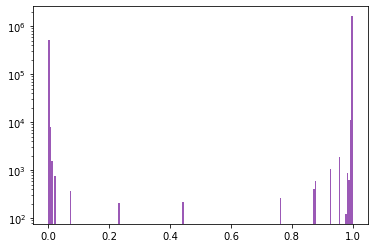

In [19]:
plt.hist(Prob_1D_predictions[:,0],bins=np.arange(0,1.001,.005))
plt.yscale("log")

/tmp/ipykernel_31507/1284966170.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Prob_1D_false_e),1-Prob_1D_true_e, label="$P_{1D}$")


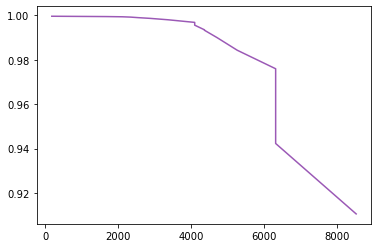

In [88]:
plt.plot(1/(1-Prob_1D_false_e),1-Prob_1D_true_e, label="$P_{1D}$")

/tmp/ipykernel_149567/2692701135.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Prob_1D_false_e),1-Prob_1D_true_e, label="$P_{1D}$")#, c="cornflowerblue")
/tmp/ipykernel_149567/2692701135.py:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-cl_pi_rej),cl_true_e, label="1D $N_{PE}$ Cut")#, c="darkorange")


[]

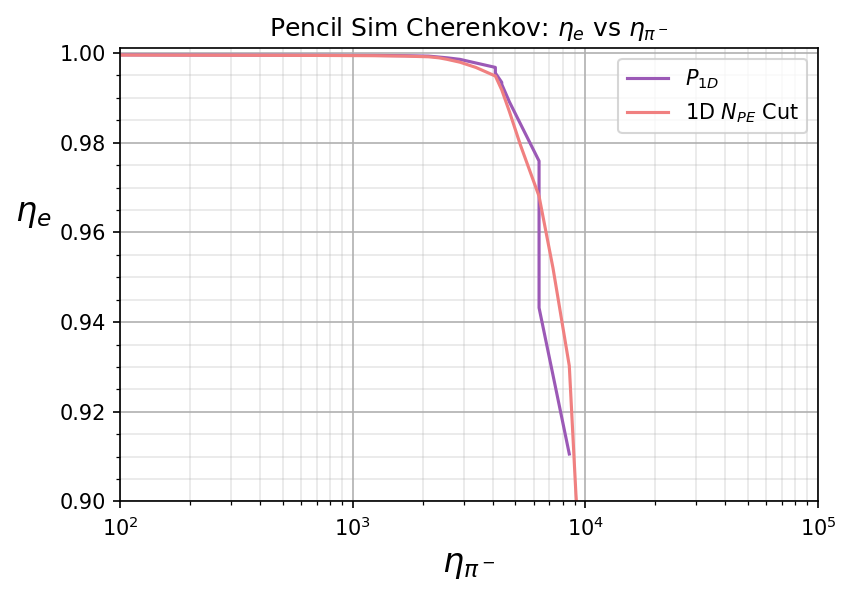

In [43]:
fig, ax = plt.subplots(dpi=150)
plt.title("Pencil Sim Cherenkov: $\eta_e$ vs $\eta_{\pi^-}$")#$\pi^-$ Rejection")
plt.ylabel("$\eta_e$",rotation=0, fontsize=16)
ax.yaxis.set_label_coords(-.125, .6)
#plt.xlabel("$\pi^-$ Rejection")
plt.xlabel("$\eta_{\pi^-}$", fontsize=16)

#plt.plot(1/(1-baseline_false_e),1-baseline_true_e, label="baseline", c="#9b59b6")
#plt.scatter(1/(1-MLP_NPE_false_e),1-MLP_NPE_true_e, label="MLP")#, c="cornflowerblue")
plt.plot(1/(1-Prob_1D_false_e),1-Prob_1D_true_e, label="$P_{1D}$")#, c="cornflowerblue")

#plt.plot(1/(1-CNN_false_e),1-CNN_true_e, label="CNN")#, c="#2ecc71")
#plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Both", c="#9b59b6")
plt.plot(1/(1-cl_pi_rej),cl_true_e, label="1D $N_{PE}$ Cut")#, c="darkorange")
#plt.plot(1/(1-baseline_false_e_part2),1-baseline_true_e_part2, c="green", alpha=.4)

#plt.plot(1/(1-GeV8_false_e),1-GeV8_true_e, label="GeV(6,8]", c="darkorange")
#plt.plot(1/(1-GeV10_false_e),1-GeV10_true_e, label="GeV(8,10]", c="fuchsia")
#plt.plot(1/(1-GeV12_false_e),1-GeV12_true_e, label="GeV(10,12]", c="saddlebrown")


#plt.vlines(0.95, .6,.1, color="firebrick", label="95% $Bkg_{rej}$") #label="95% $\pi^-_{rej}$")
#plt.plot([0.6,.1], [.95,.95], c="coral", label="95% $e_{eff}$")
#plt.scatter(50,.9, marker="*",s=150,c="magenta",zorder=100,label="ECal PCDR")

#plt.plot([0,1],[1,0])

#get handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
#order = [2,4,0,1,3,5,6]

#add legend to plot
plt.legend()#[handles[idx] for idx in order],[labels[idx] for idx in order])

#ax.set_xticks(np.arange(0,501,25), minor=1)
ax.set_yticks(np.arange(0.5,1.1,.02))
ax.set_yticks(np.arange(0.5,1.1,.005), minor=1)

plt.xlim(1e2,1e5)#(test_labels==1).sum())#1e6)
plt.ylim(0.9,1.001)

plt.xscale("log")
#plt.yscale("log")

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)

#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_LowMom_v2.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_ECal.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_ECal_log.pdf")

plt.plot()